General imports and definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table, join, vstack, hstack
import astropy.units as au
import astropy.constants as ac 
import astropy.io.ascii as asciitable
import scipy.interpolate as interp
import scipy.ndimage
from astropy.io import ascii

import bindensity

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in" 

cmap = mpl.cm.get_cmap('tab20')
cmap1 = cmap(np.arange(0,1,0.1))
cmap2 = cmap(np.arange(0.05,1,0.1))

Functions for SF relations

In [2]:
"""Star formation relations"""

def get_starK98(Sigma_gas):
    '''Schmidt law from Kennicutt (1998)
    Sigma_mol = surface density of molecular + atomic gas (Msun/pc^2)
    Sigma_SFR = surface density of star formation rate (Msun/kpc^2/yr)'''
    A = 2.5e-4
    N = 1.4
    Sigma_SFR = A * (Sigma_gas**N)
    return Sigma_SFR

def get_starB08(Sigma_mol):
    '''Schmidt law from Bigiel+ (2008)
    Sigma_mol = surface density of molecular gas (Msun/pc^2)
    Sigma_SFR = surface density of star formation rate (Msun/kpc^2/yr)
    [Note that I have divided this by a factor of 10 rwt the Bigiel+ (2008), which is in units of Msun/10]'''
    A = 10**-3.1
    N = 1
    Sigma_SFR = A * (Sigma_mol**N)
    return Sigma_SFR

Determine Sigma for CMZ assuming two assumptions of the geometry of the system - an edge-on disc or ring and a face-on ring - using the range of molecular gas mass and star formation rates determined for the central 1 deg of the Milky Way.

In [3]:
"""Geometry"""

def get_areadisc(R):
    """Surface area (A) of ring with outer radius R"""
    A = np.pi*(R**2)
    return(A)

def get_areaannulus(R, deltaR):
    """Surface area (A) of annulus with outer radius R and width deltaR"""
    A = np.pi*(R**2 - (R-deltaR)**2)
    return(A)

def get_arearectangle(L, H):
    """Surface area (A) of rectangle with length L and height H"""
    A = L*H
    return(A)

def get_surfacedensity(A, p, log=True):
    """Surface area of annulus with outer radius R and width deltaR
    log=True returns log10 units"""
    Sigma = p/A
    if log: 
        Sigma=np.log10(Sigma)
    return(Sigma)

In [4]:
"""CMZ properties"""

area_flat = get_arearectangle(200, 20)
area = get_areadisc(100) #ring

sfr_CMZ = 0.012
gas_CMZ = 1.8e7

Sigmagas_CMZring_L = get_surfacedensity(area, gas_CMZ)
Sigmasfr_CMZring_L = get_surfacedensity(area, sfr_CMZ)+6 

sfr_CMZ = 0.14
gas_CMZ = 5.3e7

Sigmagas_CMZring_H = get_surfacedensity(area, gas_CMZ)
Sigmasfr_CMZring_H = get_surfacedensity(area, sfr_CMZ)+6

sfr_CMZ = 0.07
gas_CMZ = 3.55e7

Sigmagas_CMZring = get_surfacedensity(area, gas_CMZ)
Sigmasfr_CMZring = get_surfacedensity(area, sfr_CMZ)+6

In [5]:
print('%0.1f %0.1f' %(Sigmagas_CMZring, Sigmasfr_CMZring))
print('%0.1f %0.1f' %(Sigmagas_CMZring_L, Sigmasfr_CMZring_L))
print('%0.1f %0.1f' %(Sigmagas_CMZring_H, Sigmasfr_CMZring_H))

3.1 0.3
2.8 -0.4
3.2 0.6


In [6]:
# print('[INFO] Area fraction ring/flat %0.2f \n' %(area_ring/area_flat))

# print('[INFO] Sigma GAS ring low log(): %0.2f' %(Sigmagas_CMZring_L))
# print('[INFO] Sigma SFR ring low log(): %0.2f \n' %(Sigmasfr_CMZring_L))

# print('[INFO] Sigma GAS ring low log(): %0.2f' %(Sigmagas_CMZring_H))
# print('[INFO] Sigma SFR ring low log(): %0.2f \n' %(Sigmasfr_CMZring_H))

# print('[INFO] Sigma GAS ring low log(): %0.2f' %(Sigmagas_CMZring))
# print('[INFO] Sigma SFR ring low log(): %0.2f \n' %(Sigmasfr_CMZring))

Define the literature gas and star formation rate surface densities - taken from Krumholz 2014 - please see there for references. Note that most of these are in units of msun/pc^2/Myr but this is the same as msun/kpc^2/yr!

In [7]:
"""literature properties"""

Sigmagas_K98_L = np.log10(0.05e2)
Sigmagas_K98_H = np.log10(0.20e2)
Sigmasfr_K98_L = np.log10(0.0024)
Sigmasfr_K98_H = np.log10(0.017)

Sigmagas_D10SB_L = np.log10(3.0e2)
Sigmagas_D10SB_H = np.log10(100e2)
Sigmasfr_D10SB_L = np.log10(3.9)
Sigmasfr_D10SB_H = np.log10(560)

Sigmagas_D10BzK_L = np.log10(2.0e2)
Sigmagas_D10BzK_H = np.log10(10e2)
Sigmasfr_D10BzK_L = np.log10(0.28)
Sigmasfr_D10BzK_H = np.log10(2.7)

# 10**Sigmasfr_CMZring, 10**Sigmagas_CMZring
# # table = Table.read('./../data_lada/galaxies_MJD.csv')
# # table['logLHCN'].unit = au.K * au.km/ au.s/ au.pc**2
# # table['logLIR'].unit = au.Lsun

In [8]:
"""literature properties - Bigiel 2008"""

table_B08in = asciitable.read('./../data_sk/bigiel08_in.txt', Reader=asciitable.Cds)
table_B08out = asciitable.read('./../data_sk/bigiel08_out.txt', Reader=asciitable.Cds)

table_B08in['logGAS'] = np.log10(10**table_B08in['logHI'].quantity.value + 10**table_B08in['logH2'].quantity.value) *table_B08in['logH2'].unit
table_B08out['logSFR'] = np.log10(table_B08out['SFR'].quantity.value *1e-5) *table_B08in['logSFR'].unit

sigmag_bigiel = table_B08in['logGAS']
sigmasfr_bigiel = table_B08in['logSFR']

/Users/ashleybarnes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


In [9]:
# """literature properties - Bolatto 2011"""

# contours_B11 = np.loadtxt('./../data_sk/bolatto2011_12pc.dat', skiprows=2)
# contours_B11[np.isnan(contours_B11)] = 0
# contours_B11 = contours_B11/contours_B11.max()
# contoursXlim_B11 = np.loadtxt('./../data_sk/bolatto2011_12pc.dat', max_rows=1)
# contoursYlim_B11 = np.loadtxt('./../data_sk/bolatto2011_12pc.dat', skiprows=1, max_rows=1)

# ax.contour(scipy.ndimage.zoom(contours_B11, 1), 
#             extent=(contoursXlim_B11.min(), contoursXlim_B11.max(), contoursYlim_B11.min(), contoursYlim_B11.max()),
#             levels=[0.1,0.2,0.3,0.5,0.7,0.9,0.99],
#             colors=cmap1[2].reshape(-1,4), alpha=1)

# fig

In [10]:
# Define unit conversions
pc=3.09e18
kpc=1e3*pc
msun=1.99e33
myr=3.16e13
g=6.67e-8
msunpc2=msun/pc**2
msunpc2myr=msunpc2/myr

# Choice of CO alpha factor scalings NORMALIZED TO DADDI'S CONVENTIONS
alphasb = 1.0      # starburst value
alphahiz = 1.0     # high-z disk
alphaz0 = 1.0      # z=0 scaling
alphathings = 4.6/4.4 # THINGS data value

# Parameters
sigmagmc=85*msun/pc**2    # GMC surface density in normal galaxies
phip=3.0                  # pressure normalized to isothermal gas disk value
vdisp1=0.8e6                # ISM velocity dispersion in local galaxies
vdisp2=3e6                # ISM velocity dispersion in high-z galaxies and SBs
q=1.0                     # Toomre Q
betasb=1.0                # Index of rotation curve in SBs (solid body)
betadisk=0.0              # Index of rotation curve in normal disks (flat)

In [11]:
"""literature properties - Heiderman"""

sigmag_heid=[]        # Gas surface density
sigmasfr_heid=[]      # SFR surface density

fp=open('./../data_sk/heiderman.txt', 'r')
for line in fp:
    spl=line.split()
    sigmag_heid.append(float(spl[14]))
    sigmasfr_heid.append(float(spl[20]))

fp.close()
sigmag_heid = np.array(sigmag_heid)*msun/pc**2
sigmasfr_heid = np.array(sigmasfr_heid)*msun/pc**2/myr

sigmag_heid = np.log10(sigmag_heid/msunpc2)
sigmasfr_heid = np.log10(sigmasfr_heid/msunpc2myr)
sigmag_heid,sigmasfr_heid

(array([1.80821097, 1.76267856, 1.77232171, 1.87506126, 2.0211893 ,
        1.95424251, 2.13987909, 1.96801571, 1.96567197, 1.83695674,
        1.67669361, 1.95951838, 1.96425963, 1.73957234, 1.77158748,
        1.82930377, 1.78031731, 1.69108149, 1.93043959, 2.13353891]),
 array([-0.21824463, -0.43533394,  0.04139269,  0.07554696,  0.38916608,
         0.1172713 ,  0.5171959 , -0.68402965, -0.06854213, -0.11013828,
        -1.44733178,  0.372912  ,  0.5276299 , -0.4225082 , -0.96657624,
         0.22010809, -0.03857891, -0.35654732, -0.46470588,  0.30319606]))

In [12]:
"""literature properties - Lada"""

# Lada data; masses for A_K = 0.1 and 0.8 contours
mass_lada1=np.array([67714., 71828., 99930., 18438., 14964., 14165., 1137., 7937., 2157., 1379., 787.])*msun
mass_lada2=np.array([13721., 7261., 3199., 1880., 1766., 1296., 258., 178., 163., 124., 75.])*msun
sfr_lada=np.array([715., 159., 70., 150., 84., 79., 25., 5., 17., 3., 3.])*msun/myr

sigmag_lada2=116.*2.*msun/pc**2
sigmag_lada1=np.array([sigmag_lada2/8.0]*len(mass_lada2))
area_lada1=mass_lada1/sigmag_lada1
area_lada2=mass_lada2/sigmag_lada2
sigmasfr_lada1=sfr_lada/area_lada1
sigmasfr_lada2=sfr_lada/area_lada2/3.0

sigmag_lada = np.log10(sigmag_lada1/msunpc2)
sigmasfr_lada = np.log10(sigmasfr_lada1/msunpc2myr)

In [13]:
"""literature properties - Genzel"""

sigmag_genzel=[]
sigmasfr_genzel=[]
sigmagtdyn_genzel=[]
sb_genzel=[]
fp=open('./../data_sk/genzel_ks.dat', 'r')

for line in fp:
    if line[0]=='#':
        continue
    spl=line.split()
    if spl[0]=='Name':
        continue
    sigmag_genzel.append(10.0**float(spl[11])*msun/pc**2)
    sigmagtdyn_genzel.append(10.0**float(spl[12])/(2.0*np.pi)*msun/pc**2/myr)
    sigmasfr_genzel.append(10.0**float(spl[13])*msun/pc**2/myr)
    # Apply CO scalings
    if spl[0][0:3]=='SMM':
        # sub-mm galaxy, so use starburst scalings; Genzel uses alpha = 1.0
        # for starbursts, and Daddi's convention is 0.8
        sb_genzel.append(True)
        sigmag_genzel[-1] = sigmag_genzel[-1]*0.8/1.0*alphasb
        sigmagtdyn_genzel[-1] = sigmagtdyn_genzel[-1]*0.8/1.0*alphasb
    else:
        # non-sub-mm galaxy, so use normal high z scalings; Genzel uses
        # alpha = 3.2, Daddi uses 3.6
        sb_genzel.append(False)
        sigmag_genzel[-1] = sigmag_genzel[-1]*3.6/3.2*alphahiz
        sigmagtdyn_genzel[-1] = sigmagtdyn_genzel[-1]*3.6/3.2*alphahiz
fp.close()

sigmag_genzel = np.array(sigmag_genzel)
sigmasfr_genzel = np.array(sigmasfr_genzel)

sigmag_genzel = np.log10(sigmag_genzel/msunpc2)
sigmasfr_genzel = np.log10(sigmasfr_genzel/msunpc2myr)

In [14]:
"""literature properties - Bouche"""

sigmag_bouche=[]
sigmasfr_bouche=[]
sigmagtdyn_bouche=[]
fp=open('./../data_sk/KS_2_Bouche.dat', 'r')
for line in fp:
    if line[0]=='#':
        continue
    spl=line.split()
    sigmag_bouche.append(10.0**float(spl[0])*msun/pc**2*alphasb)
    sigmagtdyn_bouche.append(10.0**float(spl[2])/(2.0*np.pi)*msun/pc**2/myr * 
                             alphasb)
    sigmasfr_bouche.append(10.0**float(spl[1])*msun/pc**2/myr)
fp.close()

sigmag_bouche = np.array(sigmag_bouche)
sigmasfr_bouche = np.array(sigmasfr_bouche)

sigmag_bouche = np.log10(sigmag_bouche/msunpc2)
sigmasfr_bouche = np.log10(sigmasfr_bouche/msunpc2myr)

In [15]:
"""literature properties - Daddi z = 0.5"""

sigmag_daddiz05=[]
sigmasfr_daddiz05=[]
sigmagtdyn_daddiz05=[]

fp=open('./../data_sk/KS_2_Daddiz05.dat', 'r')
for line in fp:
    if line[0]=='#':
        continue
    if line[0]=='\n':
        continue
    spl=line.split()
    sigmag_daddiz05.append(10.0**float(spl[1])*msun/pc**2*alphahiz)
    sigmagtdyn_daddiz05.append(10.0**float(spl[2])*msun/pc**2/myr * 
                               alphahiz)
    sigmasfr_daddiz05.append(10.0**float(spl[0])*msun/pc**2/myr)
fp.close()

sigmag_daddiz05 = np.array(sigmag_daddiz05)
sigmasfr_daddiz05 = np.array(sigmasfr_daddiz05)

sigmag_daddiz05 = np.log10(sigmag_daddiz05/msunpc2)
sigmasfr_daddiz05 = np.log10(sigmasfr_daddiz05/msunpc2myr)

In [16]:
"""literature properties - Daddi z = 2"""

sigmag_daddiz2=[]
sigmasfr_daddiz2=[]
sigmagtdyn_daddiz2=[]

fp=open('./../data_sk/KS_2_Daddi.dat', 'r')
for line in fp:
    if line[0]=='#':
        continue
    if line[0]=='\n':
        continue
    spl=line.split()
    sigmag_daddiz2.append(float(spl[0])*msun/pc**2*alphahiz)
    sigmagtdyn_daddiz2.append(float(spl[2])*msun/pc**2/myr *alphahiz)
    sigmasfr_daddiz2.append(float(spl[1])*msun/pc**2/myr)
fp.close()

sigmag_daddiz2 = np.array(sigmag_daddiz2)
sigmasfr_daddiz2 = np.array(sigmasfr_daddiz2)

sigmag_daddiz2 = np.log10(sigmag_daddiz2/msunpc2)
sigmasfr_daddiz2 = np.log10(sigmasfr_daddiz2/msunpc2myr)

In [17]:
"""literature properties - Tacconi"""

sigmag_tacconi=[]
sigmasfr_tacconi=[]
sigmagtdyn_tacconi=[]

fp=open('./../data_sk/Tacconi_KS.dat', 'r')
for line in fp:
    if line[0]=='#':
        continue
    if line[0]=='\n':
        continue
    spl=line.split()
    sigmag_tacconi.append(10.0**float(spl[1])*msun/pc**2*alphahiz)
    sigmagtdyn_tacconi.append(10.0**float(spl[2])*msun/pc**2/myr * 
                              alphahiz)
    sigmasfr_tacconi.append(10.0**float(spl[0])*msun/pc**2/myr)
fp.close()

sigmag_tacconi = np.array(sigmag_tacconi)
sigmasfr_tacconi = np.array(sigmasfr_tacconi)

sigmag_tacconi = np.log10(sigmag_tacconi/msunpc2)
sigmasfr_tacconi = np.log10(sigmasfr_tacconi/msunpc2myr)

In [18]:
"""literature properties - Tacconi 2012"""

name_tacconi12=[]
sigmag_tacconi12=[]
sigmasfr_tacconi12=[]
tdyn_tacconi12=[]
sb_tacconi12=[]

fp=open('./../data_sk/tacconi12.txt', 'r')
fp.readline()
fp.readline()
for line in fp:
    spl=line.split()
    if spl[2]=='...':
        continue
    name_tacconi12.append(spl[0])
    sigmag_tacconi12.append(10.**float(spl[-2])*msunpc2)
    sigmasfr_tacconi12.append(10.**float(spl[-1])*msunpc2myr)
    tdyn_tacconi12.append(2*np.pi*float(spl[3])*kpc/(float(spl[2])*1e5))
    sb_tacconi12.append('merger' in spl[1].lower() or 'amor' in spl[1].lower())
fp.close()

sigmag_tacconi12 = np.array(sigmag_tacconi12)
sigmasfr_tacconi12 = np.array(sigmasfr_tacconi12)

sigmag_tacconi12 = np.log10(sigmag_tacconi12/msunpc2)
sigmasfr_tacconi12 = np.log10(sigmasfr_tacconi12/msunpc2myr)

In [19]:
"""literature properties - Kennicutt ULIRG"""

sigmag_kenn_ulirg=[]
sigmasfr_kenn_ulirg=[]
tdyn_kenn_ulirg=[]

fp=open('./../data_sk/KS_2_KennUlirgs.dat', 'r')
for line in fp:
    if line[0]=='#':
        continue
    if line[0]=='\n':
        continue
    spl=line.split()
    if spl[2]=='-1':
        continue
    sigmag_kenn_ulirg.append(10.0**float(spl[0])*msun/pc**2*alphasb)
    sigmasfr_kenn_ulirg.append(10.0**float(spl[1])*msun/pc**2/myr)
    tdyn_kenn_ulirg.append(float(spl[2])*100*myr)
fp.close()

sigmag_kenn_ulirg = np.array(sigmag_kenn_ulirg)
sigmasfr_kenn_ulirg = np.array(sigmasfr_kenn_ulirg)

sigmag_kenn_ulirg = np.log10(sigmag_kenn_ulirg/msunpc2)
sigmasfr_kenn_ulirg = np.log10(sigmasfr_kenn_ulirg/msunpc2myr)

In [20]:
"""literature properties - Kennicutt spiral"""

sigmag_kenn_spiral=[]
sigmasfr_kenn_spiral=[]
tdyn_kenn_spiral=[]

fp=open('./../data_sk/KS_2_KennSpirals.dat', 'r')
for line in fp:
    if line[0]=='#':
        continue
    if line[0]=='\n':
        continue
    spl=line.split()
    if spl[2]=='-1':
        continue
    sigmag_kenn_spiral.append(10.0**float(spl[0])*msun/pc**2*alphasb)
    sigmasfr_kenn_spiral.append(10.0**float(spl[1])*msun/pc**2/myr)
    tdyn_kenn_spiral.append(float(spl[2])*100*myr)
fp.close()

sigmag_kenn_spiral = np.array(sigmag_kenn_spiral)
sigmasfr_kenn_spiral = np.array(sigmasfr_kenn_spiral)

sigmag_kenn_spiral = np.log10(sigmag_kenn_spiral/msunpc2)
sigmasfr_kenn_spiral = np.log10(sigmasfr_kenn_spiral/msunpc2myr)

In [21]:
"""literature properties - Davis 2014"""

data_davis14=ascii.read('./../data_sk/DAVIS14_WISEsfrs.txt')

sigmag_davis14 = np.array(data_davis14['Sig_gas'])*msunpc2
sigmasfr_davis14 = np.array(data_davis14['SFR'])*msunpc2myr

sigmag_davis14 = np.log10(sigmag_davis14/msunpc2)
sigmasfr_davis14 = np.log10(sigmasfr_davis14/msunpc2myr)

In [22]:
"""literature properties - Evans 2013"""

evansdat=ascii.read('./../data_sk/logsdens.dat')
evansdat1=ascii.read('./../data_sk/logsdens1.dat')
evansdat2=ascii.read('./../data_sk/logsdensu.dat')

logsigmagtff_evans=evansdat['col1']
logsigmasfr_evans=evansdat['col4']

logsigmagtff_evans1=evansdat1['col1']
logsigmasfr_evans1=evansdat1['col4']
logsigmasfrerr_evans1=evansdat1['col6']

logsigmagtff_evans2=evansdat2['col1']
logsigmasfr_evans2=evansdat2['col4']
logsigmasfrerr_evans2=evansdat2['col6']

In [23]:
"""literature properties - Lada 2013 / Lombardi data"""

ladadat=ascii.read('./../data_sk/lombardi3.dat')
arealada=ladadat['AREA'].data*pc**2
sigmaSFRlada=ladadat['NSTARS'].data*0.25*msun/(0.25*myr)/arealada
sigmaSFRerrlada=np.sqrt(ladadat['NSTARS'].data)*0.25*msun/(0.25*myr)/arealada
AKtosigmag = 183*msun/pc**2
sigmaglada=ladadat['AK_MEAN']*AKtosigmag
masslada=sigmaglada*arealada
areadifflada=arealada[:-1]-arealada[1:]
massdifflada=masslada[:-1]-masslada[1:]
sigmaSFRdifflada=(ladadat['NSTARS'].data[:-1] - ladadat['NSTARS'].data[1:]) *0.25*msun/(0.25*myr) / areadifflada
sigmaSFRdifferrlada=np.sqrt(ladadat['NSTARS'].data[:-1] - ladadat['NSTARS'].data[1:]) *0.25*msun/(0.25*myr) / areadifflada
sigmagdifflada=massdifflada/areadifflada

sigmag_lada13 = np.log10(sigmagdifflada/msunpc2)
sigmasfr_lada13 = np.log10(sigmaSFRdifflada/msunpc2myr)

/Users/ashleybarnes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


In [24]:
"""literature properties - Gutermuth 2011"""

gutermuthdata=ascii.read('./../data_sk/gutermuth11.txt')
area_gutermuth11=gutermuthdata['Area[pc^2]']*pc**2
mass_gutermuth11=gutermuthdata['Mass[msol]']*msun
sigmag_gutermuth11=mass_gutermuth11/area_gutermuth11
nstar_gutermuth11=gutermuthdata['N_II']
sigmasfr_gutermuth11=nstar_gutermuth11*0.5*msun/(2.0*myr)/area_gutermuth11

sigmag_gutermuth11 = np.log10(sigmag_gutermuth11/msunpc2)
sigmasfr_gutermuth11 = np.log10(sigmasfr_gutermuth11/msunpc2myr)

In [25]:
"""literature properties - Wu 2010"""

wudata=ascii.read('./../data_sk/wu10.txt')
area_wu10=wudata['Area']*pc**2
sigmag_wu10=10.**wudata['logSig_gas']*msunpc2
sigmasfr_wu10=10.**wudata['logSig_SFR']*msunpc2myr

sigmag_wu10 = np.log10(sigmag_wu10/msunpc2)
sigmasfr_wu10 = np.log10(sigmasfr_wu10/msunpc2myr)

Plotting

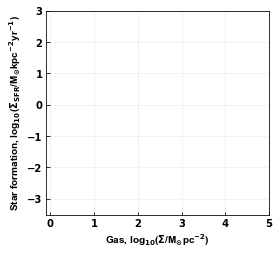

In [26]:
fig = plt.figure(figsize = (4, 3.75))
ax = fig.add_subplot(111)

xl = 'Gas, log$_{10}$($\Sigma$/M$_\mathrm{\odot}$pc$^{-2}$)'
yl = 'Star formation, log$_{10}$($\Sigma_\mathrm{SFR}$/M$_\mathrm{\odot}$kpc$^{-2}$yr$^{-1}$)'
ax.set_xlabel(xl, fontname="Arial", weight='heavy')
ax.set_ylabel(yl, fontname="Arial", weight='heavy')

ax.set_xlim(-0.1, 5)
ax.set_ylim(-3.5, 3)

ax.grid(True, ls=':', zorder=-1, alpha=0.5)

In [27]:
"""CMZ properties"""
# x = np.mean([Sigmagas_CMZring_L, Sigmagas_CMZring_H])
# y = np.mean([Sigmasfr_CMZring_L, Sigmasfr_CMZring_H])
x = Sigmagas_CMZring
y = Sigmasfr_CMZring
print(x,y)

xerr = np.array([[(x-Sigmagas_CMZring_L)], [(Sigmagas_CMZring_H-x)]])
yerr = np.array([[(y-Sigmasfr_CMZring_L)], [(Sigmasfr_CMZring_H-y)]])
print(xerr)
print(yerr)

ax.errorbar([x],[y],xerr=xerr,yerr=yerr,
            zorder=11, c='C0', 
            capsize=3, 
            elinewidth=2,
            capthick=2)

ax.scatter(x,y, fc=cmap2[0], ec=cmap1[0], lw=2, zorder=11)

factor = np.log10((100**2-90**2)/(100**2))
# print(factor)
ax.scatter(x-factor,y-factor, fc=cmap2[0], ec=cmap1[0], lw=2, zorder=11, s=20, alpha=1, marker='^')
# ax.plot([x,x-factor], [y,y-factor], c=cmap1[0], lw=2, ls='--', zorder=2, alpha=1)

factor = np.log10((200*20)/(np.pi*(100**2)))
# print(factor)
ax.scatter(x-factor,y-factor, fc=cmap2[0], ec=cmap1[0], lw=2, zorder=11, s=20, alpha=1, marker='s')
ax.plot([x,x-factor], [y,y-factor], c=cmap1[0], lw=2, ls='--', zorder=2, alpha=1)

3.05307848036096 0.3479481673201228
[[0.29495585]
 [0.17404752]]
[[0.76591679]
 [0.30103   ]]


In [28]:
x

3.05307848036096

In [29]:
# binsx_c, binsy_c, counts = bindensity.get_bindensity_2d(sigmag_bigiel, sigmasfr_bigiel, sigma=1)
# ax.contour(scipy.ndimage.zoom(counts/counts.max(), 0.4), 
#            extent=(binsx_c.min(), binsx_c.max(), binsy_c.min(), binsy_c.max()),
#            levels=[0.01,0.1,0.5,0.75,0.95], 
#            colors=cmap1[1].reshape(-1,4), alpha=1, zorder=-1)

In [30]:
sigmag_all = np.array(np.hstack([sigmag_bigiel, sigmag_heid, sigmag_lada, 
                        sigmag_genzel, sigmag_bouche, sigmag_daddiz05,
                        sigmag_daddiz2, sigmag_tacconi, sigmag_kenn_ulirg,
                        sigmag_kenn_spiral, sigmag_davis14, sigmag_lada13, 
                        sigmag_gutermuth11, sigmag_wu10]))

sigmasfr_all = np.array(np.hstack([sigmasfr_bigiel, sigmasfr_heid, sigmasfr_lada, 
                        sigmasfr_genzel, sigmasfr_bouche, sigmasfr_daddiz05,
                        sigmasfr_daddiz2, sigmasfr_tacconi, sigmasfr_kenn_ulirg,
                        sigmasfr_kenn_spiral, sigmasfr_davis14, sigmasfr_lada13, 
                        sigmasfr_gutermuth11, sigmasfr_wu10]))

sigmag_all = sigmag_all[~np.isinf(sigmasfr_all)]
sigmasfr_all = sigmasfr_all[~np.isinf(sigmasfr_all)]
sigmag_all = sigmag_all[sigmasfr_all!=0]
sigmasfr_all = sigmasfr_all[sigmasfr_all!=0]

x, y = sigmag_all, sigmasfr_all

ax.scatter(x, y, ec='none', fc='grey', s=25)
ax.scatter(x, y, ec='none', fc='white', s=12)

# ax.scatter(x, y, ec='none', fc='grey', s=12, ec='none', alpha=0.2)

In [31]:
l_B08 = ax.scatter(sigmag_bigiel, sigmasfr_bigiel, s=12, ec='none', alpha=0.2, c=cmap1[3])
l_kenn_spiral = ax.scatter(sigmag_kenn_spiral, sigmasfr_kenn_spiral, s=12, ec='none', alpha=0.2, c=cmap1[3])
l_davis14 = ax.scatter(sigmag_davis14, sigmasfr_davis14, s=12, ec='none', alpha=0.2, c=cmap1[3])

l_kenn_ulirg = ax.scatter(sigmag_kenn_ulirg, sigmasfr_kenn_ulirg, s=12, ec='none', alpha=0.4, c=cmap1[1])

l_genzel = ax.scatter(sigmag_genzel, sigmasfr_genzel, s=12, ec='none', alpha=0.4, c=cmap1[4])
l_bouche = ax.scatter(sigmag_bouche, sigmasfr_bouche, s=12, ec='none', alpha=0.4, c=cmap1[4])
l_daddiz05 = ax.scatter(sigmag_daddiz05, sigmasfr_daddiz05, s=12, ec='none', alpha=0.4, c=cmap1[4])
l_daddiz2 = ax.scatter(sigmag_daddiz2, sigmasfr_daddiz2, s=12, ec='none', alpha=0.4, c=cmap1[4])
l_tacconi = ax.scatter(sigmag_tacconi, sigmasfr_tacconi, s=12, ec='none', alpha=0.4, c=cmap1[4])

l_heid = ax.scatter(sigmag_heid, sigmasfr_heid, s=12, ec='none', alpha=0.4, c=cmap1[2])
l_lada = ax.scatter(sigmag_lada, sigmasfr_lada, s=12, ec='none', alpha=0.4, c=cmap1[2])
l_lada13 = ax.scatter(sigmag_lada13, sigmasfr_lada13, s=12, ec='none', alpha=0.4, c=cmap1[2])
l_gutermuth11 = ax.scatter(sigmag_gutermuth11, sigmasfr_gutermuth11, s=12, ec='none', alpha=0.4, c=cmap1[2])
l_wu10 = ax.scatter(sigmag_wu10, sigmasfr_wu10, s=12, ec='none', alpha=0.4, c=cmap1[2])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

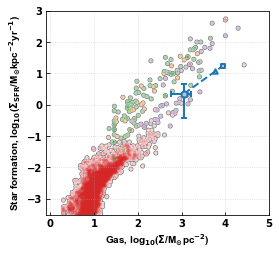

In [32]:
fig

In [33]:
"""Star formation relations"""

x = np.logspace(-15, 15, 31)
ax.plot(np.log10(x), np.log10(get_starK98(x)), linestyle='--', color = 'black', alpha=0.5, zorder=2, label='Kennicutt (1998)')
ax.plot(np.log10(x), np.log10(get_starB08(x)), linestyle=':', color = 'black', alpha=0.5, zorder=2, label='Bigiel et al. (2008)')

legend1 = ax.legend(loc='lower right',ncol=1,
            scatterpoints=1, fontsize=8)

In [34]:
plt.tight_layout()
fig.savefig('./../figs/plot_SK.pdf',bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

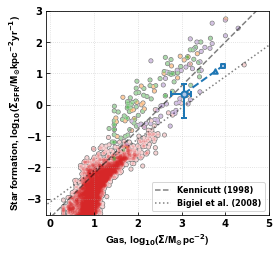

In [35]:
fig